In [47]:
%matplotlib inline
import cv2
from matplotlib import pyplot as plt
import numpy as np
import time as t
print "OpenCV Version : %s " % cv2.__version__

OpenCV Version : 3.2.0 


In [2]:
from ctypes import *
import math
import random

In [3]:
def sample(probs):
    s = sum(probs)
    probs = [a/s for a in probs]
    r = random.uniform(0, 1)
    for i in range(len(probs)):
        r = r - probs[i]
        if r <= 0:
            return i
    return len(probs)-1

In [4]:
def c_array(ctype, values):
    return (ctype * len(values))(*values)

In [5]:
class BOX(Structure):
    _fields_ = [("x", c_float),
                ("y", c_float),
                ("w", c_float),
                ("h", c_float)]

In [6]:
class IMAGE(Structure):
    _fields_ = [("w", c_int),
                ("h", c_int),
                ("c", c_int),
                ("data", POINTER(c_float))]

In [7]:
class METADATA(Structure):
    _fields_ = [("classes", c_int),
                ("names", POINTER(c_char_p))]

In [8]:
#lib = CDLL("/home/pjreddie/documents/darknet/libdarknet.so", RTLD_GLOBAL)
lib = CDLL("libdarknet.so", RTLD_GLOBAL)
lib.network_width.argtypes = [c_void_p]
lib.network_width.restype = c_int
lib.network_height.argtypes = [c_void_p]
lib.network_height.restype = c_int

In [9]:
predict = lib.network_predict_p
predict.argtypes = [c_void_p, POINTER(c_float)]
predict.restype = POINTER(c_float)

In [10]:
make_boxes = lib.make_boxes
make_boxes.argtypes = [c_void_p]
make_boxes.restype = POINTER(BOX)

In [11]:
free_ptrs = lib.free_ptrs
free_ptrs.argtypes = [POINTER(c_void_p), c_int]

In [12]:
num_boxes = lib.num_boxes
num_boxes.argtypes = [c_void_p]
num_boxes.restype = c_int

In [13]:
make_probs = lib.make_probs
make_probs.argtypes = [c_void_p]
make_probs.restype = POINTER(POINTER(c_float))

In [14]:
detect = lib.network_predict_p
detect.argtypes = [c_void_p, IMAGE, c_float, c_float, c_float, POINTER(BOX), POINTER(POINTER(c_float))]

In [15]:
reset_rnn = lib.reset_rnn
reset_rnn.argtypes = [c_void_p]

In [16]:
load_net = lib.load_network_p
load_net.argtypes = [c_char_p, c_char_p, c_int]
load_net.restype = c_void_p

In [17]:
free_image = lib.free_image
free_image.argtypes = [IMAGE]

In [18]:
letterbox_image = lib.letterbox_image
letterbox_image.argtypes = [IMAGE, c_int, c_int]
letterbox_image.restype = IMAGE

In [19]:
load_meta = lib.get_metadata
lib.get_metadata.argtypes = [c_char_p]
lib.get_metadata.restype = METADATA

In [20]:
load_image = lib.load_image_color
load_image.argtypes = [c_char_p, c_int, c_int]
load_image.restype = IMAGE

In [21]:
predict_image = lib.network_predict_image
predict_image.argtypes = [c_void_p, IMAGE]
predict_image.restype = POINTER(c_float)

In [22]:
network_detect = lib.network_detect
network_detect.argtypes = [c_void_p, IMAGE, c_float, c_float, c_float, POINTER(BOX), POINTER(POINTER(c_float))]

In [23]:
def classify(net, meta, im):
    out = predict_image(net, im)
    res = []
    for i in range(meta.classes):
        res.append((meta.names[i], out[i]))
    res = sorted(res, key=lambda x: -x[1])
    return res

In [35]:
def detect(net, meta, image, thresh=.5, hier_thresh=.5, nms=.45):
    #im = load_image(image, 0, 0)
    boxes = make_boxes(net)
    probs = make_probs(net)
    num =   num_boxes(net)
    network_detect(net, image, thresh, hier_thresh, nms, boxes, probs)
    res = []
    for j in range(num):
        for i in range(meta.classes):
            if probs[j][i] > 0:
                res.append((meta.names[i], probs[j][i], (boxes[j].x, boxes[j].y, boxes[j].w, boxes[j].h)))
    res = sorted(res, key=lambda x: -x[1])
    free_image(im)
    free_ptrs(cast(probs, POINTER(c_void_p)), num)
    return res

In [36]:
def drawLabels(img, label, col):
    cv2.rectangle(img,
                  (int(label[2][0] - label[2][2] / 2), 
                   int(label[2][1] - label[2][3] / 2)), 
                  (int(label[2][0] + label[2][2] / 2), 
                   int(label[2][1] + label[2][3] / 2)),
                  col,
                  thickness = 3)
    
    font = cv2.FONT_HERSHEY_SIMPLEX
    textSize = cv2.getTextSize(r[0][0], font, 1, 2)
    
    cv2.rectangle(img, 
                  (int(label[2][0] - label[2][2] / 2), 
                   int(label[2][1] - label[2][3] / 2)), 
                  (int((label[2][0] - label[2][2] / 2) + textSize[0][0]), 
                   int((label[2][1] - label[2][3] / 2) - textSize[0][1])), 
                  col, 
                  thickness = -1)
    cv2.putText(img, 
                label[0],
                (int(label[2][0] - label[2][2] / 2), 
                 int(label[2][1] - label[2][3] / 2)), 
                font, 
                1,
                (0,0,0),
                2,
                cv2.LINE_AA)

In [37]:
net = load_net("cfg/yolo.cfg", "yolo.weights", 0)
im = load_image("data/horses.jpg", 0, 0)
meta = load_meta("cfg/coco.data")
r = detect(net, meta, im)
print r

[('horse', 0.9087369441986084, (156.39584350585938, 305.0424499511719, 288.21673583984375, 223.65708923339844)), ('horse', 0.8431031703948975, (82.6181869506836, 265.71527099609375, 176.24462890625, 142.2727508544922)), ('horse', 0.6192988157272339, (517.5120849609375, 280.0846252441406, 168.30894470214844, 138.16677856445312))]


In [38]:
image = cv2.imread("data/horses.jpg")
cv_rgb = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)

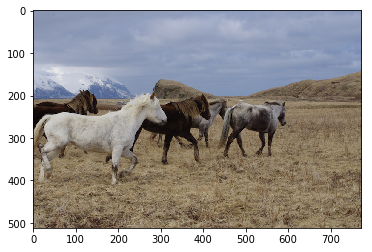

In [39]:
plt.imshow(cv_rgb)
plt.show()

In [44]:
colors = [(255, 0, 0), (255, 255, 0), (255, 0, 255), (0, 255, 0), (0, 0, 255), (0, 255, 255)]
color_map = {}
for label in r:
    if label[0] in color_map.keys():
        #print "Exists!"
        drawLabels(cv_rgb, label, color_map[label[0]])
        #print color_map[label[0]]
    else:
        rand_index = random.randint(0, len(colors))
        drawLabels(cv_rgb, label, colors[rand_index])
        #print colors[rand_index]
        color_map[label[0]] = colors[rand_index]
        del colors[rand_index]
        
    

In [45]:
len(colors)
color_map[label[0]]

(0, 255, 255)

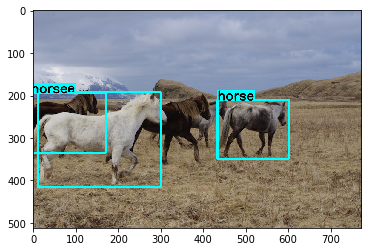

In [46]:
plt.imshow(cv_rgb)
plt.show()

In [43]:
PATH = "predictions.png"
image = cv2.imread(PATH)
cv_rgb = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)

error: /io/opencv/modules/imgproc/src/color.cpp:9716: error: (-215) scn == 3 || scn == 4 in function cvtColor


In [ ]:
plt.imshow(cv_rgb)
plt.show()